In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

print(tf.__version__)

2021-11-04 20:46:21.523814: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1


In [2]:
#Check if GPU is available
tf.config.list_physical_devices('GPU')

2021-11-04 20:46:22.584588: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-04 20:46:22.585063: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-04 20:46:22.628222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-04 20:46:22.628554: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-04 20:46:22.628592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node ze

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:

CLASSES=["fabric", "foliage", "glass", "leather", "metal", "paper", "plastic", "stone", "water", "wood"]

##  Dataset Preparation

Split the dataset ....

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

# prefetch the dataset
#https://www.tensorflow.org/tutorials/load_data/images
def configure_for_performance(ds,batch_size):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds



def getFMDdataset(image_dir,batch_size=8,img_size=(224,224)):
    CLASSES=["fabric", "foliage", "glass", "leather", "metal", "paper", "plastic", "stone", "water", "wood"]


    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(image_dir,
                                                                class_names=CLASSES,
                                                                shuffle=True,
                                                                batch_size=batch_size,
                                                                image_size=img_size,
                                                                seed=0,
                                                                validation_split=0.2,
                                                                subset="training",
                                                                interpolation='lanczos3',
                                                                #crop_to_aspect_ratio=True,
                                                               )
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory( image_dir,
                                                                class_names=CLASSES,
                                                                shuffle=True,
                                                                batch_size=batch_size,
                                                                image_size=img_size,
                                                                seed=0,
                                                                validation_split=0.2,
                                                                subset="validation",
                                                                interpolation='lanczos3',
                                            #only avail in tf 2.6 #crop_to_aspect_ratio=True,
                                                               )
    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
    val_dataset=val_dataset.prefetch(buffer_size=AUTOTUNE)

    return train_dataset,val_dataset

In [10]:

train_dataset,val_dataset= getFMDdataset("../dataset/FMD/image",8,(224,224))

Found 1000 files belonging to 10 classes.
Using 800 files for training.
Found 1000 files belonging to 10 classes.
Using 200 files for validation.


In [39]:
train_dataset=train_dataset.repeat(2)

In [40]:
 data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),

#      tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.5),
     tf.keras.layers.experimental.preprocessing.RandomZoom(.3),
 ])


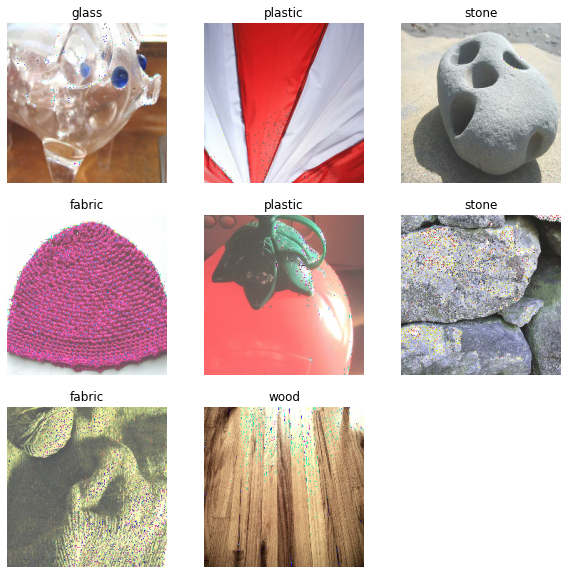

In [41]:
#visualize the dataset to ensure correctness

# original 
class_names = CLASSES
batch_size= 8
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(batch_size):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

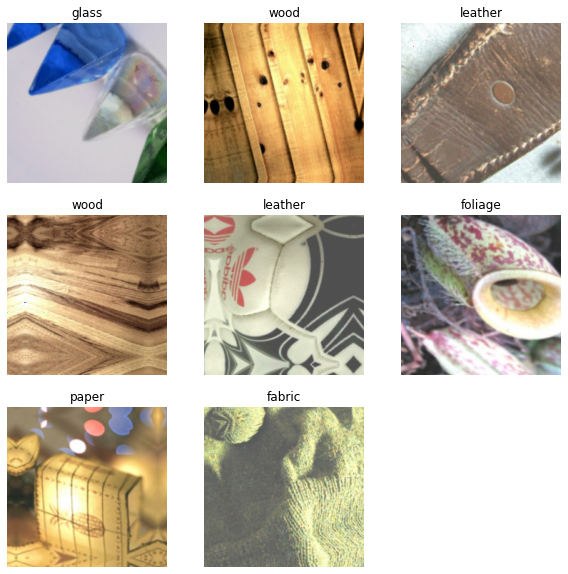

In [42]:
#visualize augmented
class_names = CLASSES
batch_size= 8
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    images=data_augmentation(images)
    for i in range(batch_size):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Model


In [43]:
def efficientnet(lr):
    base_model=tf.keras.applications.EfficientNetB0(
        include_top=False,   weights='./noisy.student.notop-b0.h5', drop_connect_rate=0.4)
    base_model.trainable=False
    base_model.training=False

    base_model._name ='base_model'
    model = tf.keras.Sequential([
        tf.keras.layers.Input((224, 224, 3)),
        data_augmentation,
        tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input, name='preprocessing', input_shape=(224, 224, 3)),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.7),
        tf.keras.layers.Dense(10,activation="softmax")    
    ])
    model.summary()

    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])

    return model

model=efficientnet(0.001)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
preprocessing (Lambda)       (None, 224, 224, 3)       0         
_________________________________________________________________
base_model (Functional)      (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

In [44]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
EARLY_STOP_PATIENCE=10
early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
model_cp = ModelCheckpoint(filepath = './weights/efficient_baseline_best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [45]:
EPOCHS=50

history = model.fit(
        train_dataset,
        epochs = EPOCHS,
        validation_data=val_dataset,
        callbacks=[model_cp, early_stopper],
        use_multiprocessing=True,
        workers=4
)

Epoch 1/50
200/200 [==============================] - 9s 29ms/step - loss: 3.3206 - accuracy: 0.2102 - top-5-accuracy: 0.6951 - val_loss: 0.9142 - val_accuracy: 0.7150 - val_top-5-accuracy: 0.9850
Epoch 2/50
200/200 [==============================] - 5s 25ms/step - loss: 1.9678 - accuracy: 0.4688 - top-5-accuracy: 0.8881 - val_loss: 0.6305 - val_accuracy: 0.7950 - val_top-5-accuracy: 0.9850
Epoch 3/50
200/200 [==============================] - 5s 25ms/step - loss: 1.5668 - accuracy: 0.5703 - top-5-accuracy: 0.9288 - val_loss: 0.6860 - val_accuracy: 0.7850 - val_top-5-accuracy: 0.9800
Epoch 4/50
200/200 [==============================] - 5s 25ms/step - loss: 1.5832 - accuracy: 0.5822 - top-5-accuracy: 0.9351 - val_loss: 0.6455 - val_accuracy: 0.7900 - val_top-5-accuracy: 0.9950
Epoch 5/50
200/200 [==============================] - 5s 25ms/step - loss: 1.5061 - accuracy: 0.5976 - top-5-accuracy: 0.9464 - val_loss: 0.6103 - val_accuracy: 0.8050 - val_top-5-accuracy: 0.9900
Epoch 6/50
200/

## Visualize result

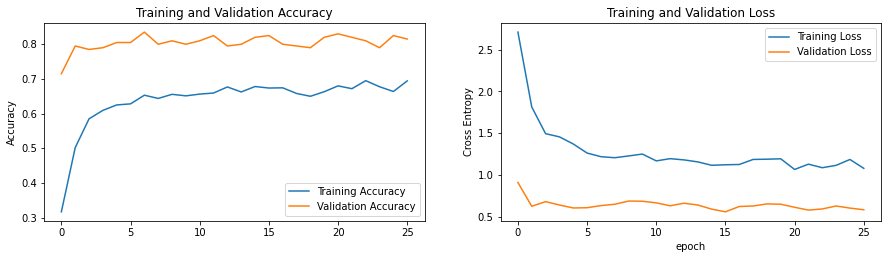

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

ROC_AUC score : 0.98 

              precision    recall  f1-score   support

      fabric       0.85      0.85      0.85        26
     foliage       0.83      0.95      0.89        21
       glass       0.67      0.57      0.62        21
     leather       0.83      0.79      0.81        19
       metal       0.59      0.93      0.72        14
       paper       0.94      0.81      0.87        21
     plastic       0.94      0.75      0.83        20
       stone       0.76      0.90      0.83        21
       water       0.95      0.86      0.90        21
        wood       0.86      0.75      0.80        16

    accuracy                           0.81       200
   macro avg       0.82      0.82      0.81       200
weighted avg       0.83      0.81      0.82       200



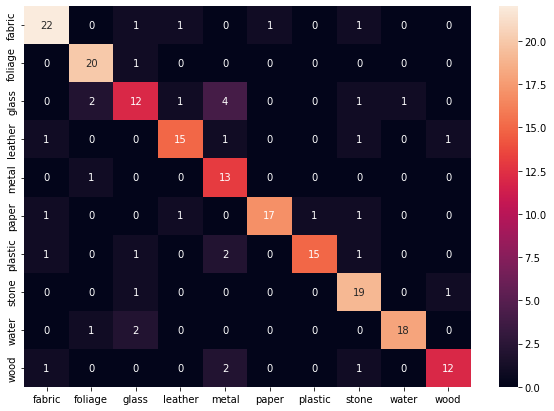

In [47]:

def print_evaluation_result(model,val_dataset,classes):
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import classification_report

    predictions_one_hot = np.array([])
    labels_one_hot =  np.array([])
    predictions = np.array([])
    labels =  np.array([])
    for x, y in val_dataset:
        categorical_labels = np.identity(10)[y.numpy()]
        prediction= model.predict(x)

        predictions_one_hot = np.concatenate([predictions_one_hot,prediction],axis=None)
        predictions = np.concatenate([predictions, np.argmax(prediction, axis=-1)],axis=None)

        labels_one_hot = np.concatenate([labels_one_hot, categorical_labels],axis=None)
        labels = np.concatenate([labels, y],axis=None)
            
    print(f'ROC_AUC score : {round(roc_auc_score(labels_one_hot, predictions_one_hot, average="weighted", multi_class="ovr"),2)} \n')
    print(classification_report(labels, predictions, target_names=classes))
    confusion_matrix= tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

    df_cm = pd.DataFrame(confusion_matrix, index = classes,
                      columns = classes)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
print_evaluation_result(model,val_dataset,CLASSES)

## Fine Tuning 

In [48]:
model.layers[2].summary()

Model: "base_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, None, None, 3 7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_1[0][0]            
_________________________________________________________________________________________

In [49]:

def unfreeze_model(model,lr,freeze_layers,print_base_layer=False):
    base_model_index=0
    for index,layer in enumerate(model.layers):
        if layer._name=="base_model":
            base_model_index=index
    if print_base_layer:
        print(model.layers[base_model_index].summary())
    model.layers[base_model_index].trainable=True

    #unfreeze the conv 3rd block
    fine_tune_at = len(model.layers[base_model_index].layers)-freeze_layers

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in model.layers[base_model_index].layers[:fine_tune_at]:
        layer.trainable =  False
        
    # just in case,explicitly freeze all the batch normalization layer
    for layer in model.layers[base_model_index].layers[fine_tune_at:]:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
              layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy',  tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])

    model.summary()


unfreeze_model(model,1e-4,16,False)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
preprocessing (Lambda)       (None, 224, 224, 3)       0         
_________________________________________________________________
base_model (Functional)      (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

In [ ]:
fine_tune_epochs = 100
initial_epochs=history.epoch[-1]
total_epochs = initial_epochs  + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=initial_epochs,
                         validation_data=val_dataset,
                        callbacks=[model_cp, early_stopper],
                        use_multiprocessing=True,
                        workers=4)

Epoch 26/125
200/200 [==============================] - 9s 29ms/step - loss: 1.1203 - accuracy: 0.6860 - top-5-accuracy: 0.9645 - val_loss: 0.6013 - val_accuracy: 0.8300 - val_top-5-accuracy: 0.9850
Epoch 27/125
200/200 [==============================] - 5s 25ms/step - loss: 1.1356 - accuracy: 0.6662 - top-5-accuracy: 0.9710 - val_loss: 0.6022 - val_accuracy: 0.8100 - val_top-5-accuracy: 0.9950
Epoch 28/125
200/200 [==============================] - 5s 25ms/step - loss: 1.0535 - accuracy: 0.7111 - top-5-accuracy: 0.9576 - val_loss: 0.5834 - val_accuracy: 0.8200 - val_top-5-accuracy: 0.9900
Epoch 29/125
200/200 [==============================] - 5s 25ms/step - loss: 0.9182 - accuracy: 0.7390 - top-5-accuracy: 0.9714 - val_loss: 0.5963 - val_accuracy: 0.8050 - val_top-5-accuracy: 0.9950
Epoch 30/125
199/200 [============================>.] - ETA: 0s - loss: 1.0110 - accuracy: 0.7053 - top-5-accuracy: 0.9767

In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

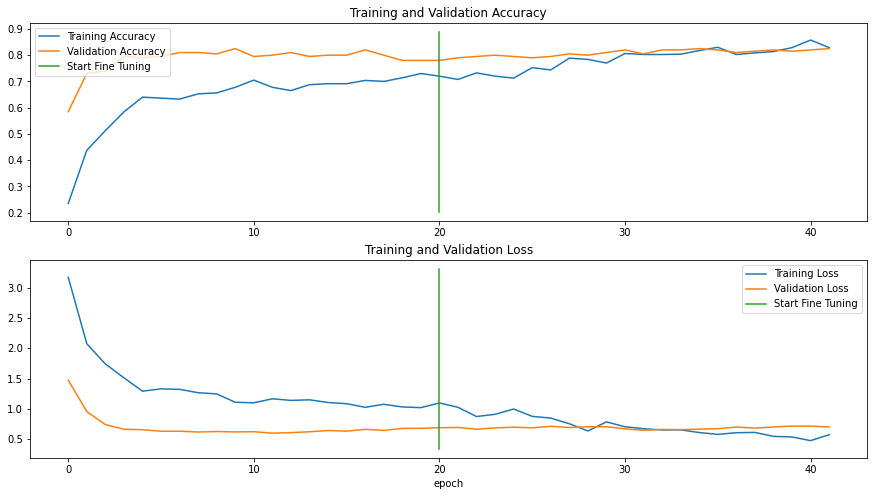

In [25]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

ROC_AUC score : 0.98 

              precision    recall  f1-score   support

      fabric       0.92      0.88      0.90        26
     foliage       0.91      0.95      0.93        21
       glass       0.81      0.62      0.70        21
     leather       0.71      0.79      0.75        19
       metal       0.55      0.86      0.67        14
       paper       0.90      0.86      0.88        21
     plastic       0.92      0.60      0.73        20
       stone       0.77      0.95      0.85        21
       water       0.95      0.95      0.95        21
        wood       0.86      0.75      0.80        16

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.84      0.82      0.82       200



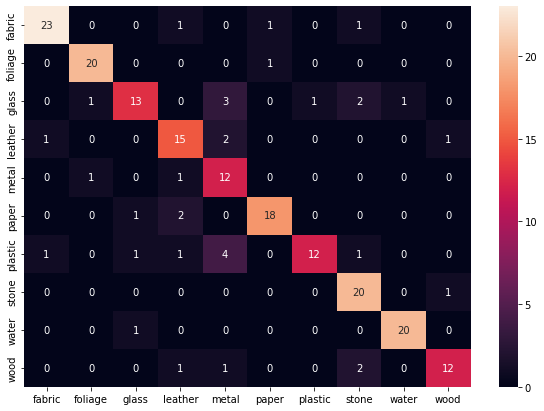

In [26]:

print_evaluation_result(model,val_dataset,CLASSES)